In [25]:
# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
import os
import tensorflow as tf
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
print(torch.version.cuda)

11.3


In [28]:
import torch
import torchvision
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('CUDA is available, Training on GPU ...')
else:
    print('CUDA is not available!  Training on CPU ...')

CUDA is not available!  Training on CPU ...


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Step 1: Load Dataset

In [29]:
data_dir = '/content/drive/My Drive/AIML/Projects/Capstone/Project_CV/Car_Images/'
train_dir = data_dir + '/Train_Images'
test_dir = data_dir + '/Test_Images'

In [30]:
validation_split=0.2
shuffle = False # This is set to false to mainitain the same order in the training data and the annotations data - explained later
batch_size = 32
image_width  = 256
image_height = 256
image_size   = (image_width, image_height)

In [31]:
training_data = tf.keras.utils.image_dataset_from_directory(
  directory=train_dir,
  label_mode='categorical',
  validation_split=validation_split,
  subset="training",
  shuffle=shuffle,
  seed=123,
  batch_size=batch_size,
  image_size = image_size)

validation_data = tf.keras.utils.image_dataset_from_directory(
  directory=train_dir,
  label_mode='categorical',
  validation_split=validation_split,
  subset="validation",
  shuffle=False,
  seed=123,
  batch_size=batch_size,
  image_size = image_size)


test_data = tf.keras.utils.image_dataset_from_directory(
  directory=test_dir,
  label_mode='categorical',
  shuffle=shuffle,
  seed=123,
  batch_size=batch_size,
  image_size = image_size)

Found 8144 files belonging to 196 classes.
Using 6516 files for training.
Found 8144 files belonging to 196 classes.
Using 1628 files for validation.
Found 8041 files belonging to 196 classes.


# Step 2: Transform the Dataset

In [32]:
# Training transform includes random rotation and flip to build a more robust model
train_transforms = transforms.Compose([transforms.Resize((244,244)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# The validation set will use the same transform as the test set
test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validation_transforms = transforms.Compose([transforms.Resize((244,244)),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir + '/Train_Images', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test_Images',transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Train_Images', transform=validation_transforms)



# Using the image datasets and the trainforms, define the dataloaders
# The trainloader will have shuffle=True so that the order of the images do not affect the model
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True )
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)

# Step 3: Create Model

In [37]:
model = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [38]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)

In [39]:
model.fc

Linear(in_features=512, out_features=196, bias=True)

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

# Step 4: Train Model

In [ ]:
# Implement a function for the validation pass
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    
    # change model to work with cuda
    model.to('cuda')

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):
    
        # Change images and labels to work with cuda
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)
        
        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [ ]:
epochs = 10
steps = 0
print_every = 40

# change to gpu mode
model.to('cuda')
model.train()
for e in range(epochs):

    running_loss = 0
    
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        # zeroing parameter gradients
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()
            
            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every,3)} \
            Valid Loss: {round(valid_loss/len(validloader),3)} \
            Valid Accuracy: {round(float(accuracy/len(validloader)),3)}")
            
            
            # Turning training back on
            model.train()
            lrscheduler.step(accuracy * 100)
           

No. epochs: 1,             Training Loss: 3.983             Valid Loss: 3.129             Valid Accuracy: 0.286
No. epochs: 2,             Training Loss: 1.053             Valid Loss: 2.213             Valid Accuracy: 0.462
No. epochs: 2,             Training Loss: 3.245             Valid Loss: 1.847             Valid Accuracy: 0.54
No. epochs: 3,             Training Loss: 1.234             Valid Loss: 1.174             Valid Accuracy: 0.719
No. epochs: 4,             Training Loss: 0.213             Valid Loss: 0.984             Valid Accuracy: 0.758
No. epochs: 4,             Training Loss: 1.144             Valid Loss: 0.781             Valid Accuracy: 0.81
No. epochs: 5,             Training Loss: 0.387             Valid Loss: 0.588             Valid Accuracy: 0.856
No. epochs: 5,             Training Loss: 1.008             Valid Loss: 0.548             Valid Accuracy: 0.857
No. epochs: 6,             Training Loss: 0.419             Valid Loss: 0.279             Valid Accuracy: 

In [ ]:
correct = 0
total = 0
model.to('cuda')


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")

Test accuracy of model: 76.993%


## Step 5: Save the Model

In [ ]:
# Saving: feature weights, new model.fc, index-to-class mapping, optimiser state, and No. of epochs
checkpoint = {'state_dict': model.state_dict(),
              'model': model.fc,
              'class_to_idx': train_data.class_to_idx,
              'opt_state': optimizer.state_dict,
              'num_epochs': epochs}

torch.save(checkpoint, '/content/drive/My Drive/AIML/Projects/Capstone/Project_CV/my_checkpoint1.pth')

## Step 6: Load the Model

In [41]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):

    checkpoint = torch.load(filepath ,map_location=torch.device('cpu'))
    
    #model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [42]:
# Loading model
model = load_checkpoint('/content/drive/My Drive/AIML/Projects/Capstone/Project_CV/my_checkpoint1.pth')
# Checking model i.e. should have 196 output units in the classifier
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
model = torch.nn.DataParallel(model)

## Step 7: Predict the Image

In [44]:
def process_image(image):
    
    # Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg')

    # Building image transform
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]) 
    
    # Transforming image for use with network
    pil_tfd = transform(pil_im)
    
    # Converting to Numpy array 
    array_im_tfd = np.array(pil_tfd)
    
    return array_im_tfd

In [45]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [49]:
def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file   
    
    # Loading model - using .cpu() for working with CPUs
    loaded_model = load_checkpoint(model).cpu()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)
        
    #conf, predicted = torch.max(output.data, 1)   
    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]
    
    # Converting probabilities and outputs to lists
    conf = np.array(probs_top)[0]
    predicted = np.array(predicted_top)[0]
        
    #return probs_top_list, index_top_list
    return conf, predicted

In [50]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(data_dir+"Train_Images")

print(classes, c_to_idx)

['.DS_Store', 'AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW Z4 Con

## Step 8: Show the result

In [55]:
def plot_solution(cardir, model):
  # Testing predict function

  # Inputs are paths to saved model and test image
  model_path = '/content/drive/My Drive/AIML/Projects/Capstone/Project_CV/my_checkpoint1.pth'
  image_path = test_dir + cardir
  carname = cardir.split('/')[1]

  conf2, predicted1 = predict(image_path, model_path, topk=5)
  # Converting classes to names
  names = []
  for i in range(5):
  
      names += [classes[predicted1[i]]]


  # Creating PIL image
  image = Image.open(image_path+'.jpg')

  # Plotting test image and predicted probabilites
  f, ax = plt.subplots(2,figsize = (6,10))

  ax[0].imshow(image)
  ax[0].set_title(carname)

  y_names = np.arange(len(names))
  ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
  ax[1].set_yticks(y_names)
  ax[1].set_yticklabels(names)
  ax[1].invert_yaxis() 

  plt.show()

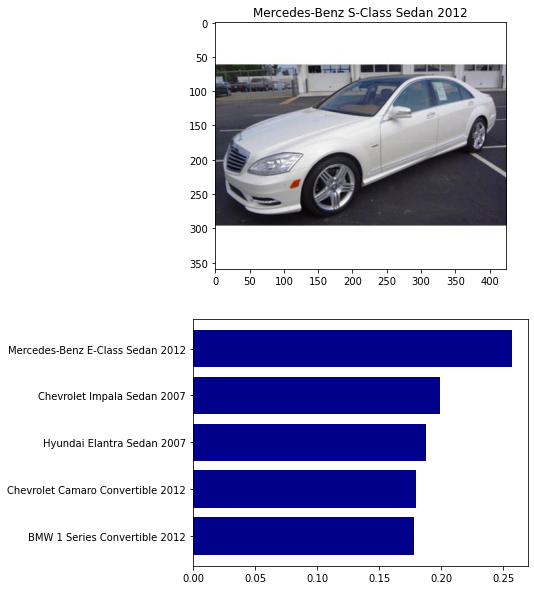

In [56]:
cardir='/Mercedes-Benz S-Class Sedan 2012/06543'
plot_solution(cardir, model)

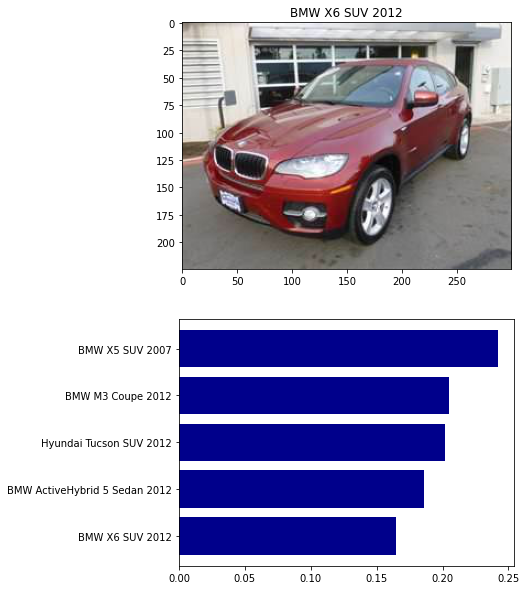

In [60]:
cardir='/BMW X6 SUV 2012/02891'
plot_solution(cardir, model)

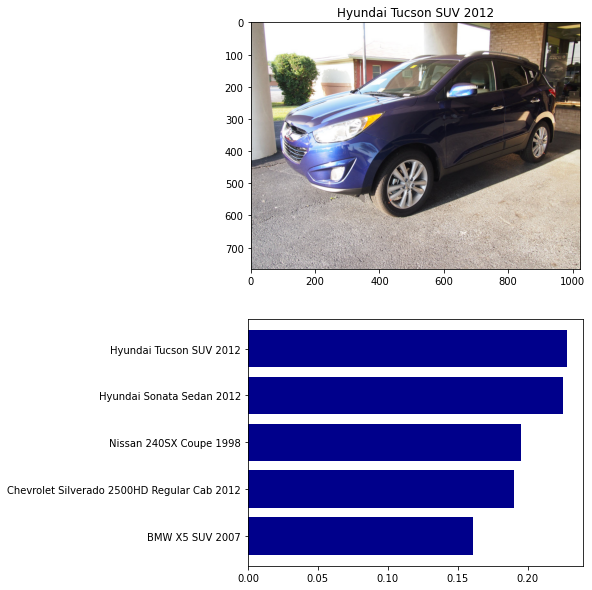

In [63]:
cardir='/Hyundai Tucson SUV 2012/07220'
plot_solution(cardir, model)